# Shallow Machine Learning Models: K-Means

### Import Libraries including from `sklearn` for shallow ML

In [1]:
# Data Wrangling
import pandas as pd
import numpy as np
import xarray as xr

# Machine Learn
from sklearn.cluster import KMeans

# Data Plotting
import matplotlib.pyplot as plt

#ignorewarnings
import warnings
warnings.filterwarnings("ignore")

<div class="alert alert-info" role="alert" 
     style="font-size: 1.8em; font-weight: bold; padding: 15px; margin: 10px 0; text-align: center; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">
    Data Preprocessing
</div>

### Load netCDF data using xarray `open_dataset`

In [2]:
# Load data from NetCDF file into xarray format
nc_ = xr.open_dataset("med-cmcc-ssh-rean-m_.nc")
# print(nc_)

In [3]:
ssh = nc_['zos'].isel(time = 0).values      # ssh from 1st timestep (2020-08-01)
lat = nc_['latitude'].values                # 1D array of latitiude
lon = nc_['longitude'].values               # 1D array of longitude

# ssh should have 2 dimensions (lat, lon):
print("Lat & Long:", lat.shape, lon.shape)
print("Data Shape:", ssh.shape)          

Lat & Long: (380,) (1016,)
Data Shape: (380, 1016)


pre-norm min: -0.56 ; pre-norm max: -0.15
normalised min: 0.0 ; normalised max: 1.0


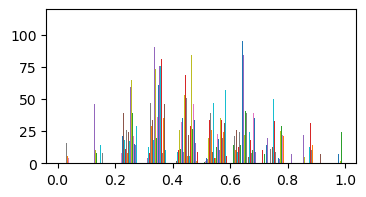

In [4]:
# Normalise ssh values using min to max scaling:
ssh_min, ssh_max = np.nanmin(ssh), np.nanmax(ssh)
print(f"pre-norm min: {ssh_min:.2f} ; pre-norm max: {ssh_max:.2f}")

# Normalisation of ssh values to between 0 and 1
ssh_norm = (ssh - ssh_min) / (ssh_max - ssh_min)
print("normalised min:", np.nanmin(ssh_norm ), "; normalised max:", np.nanmax(ssh_norm ))

# Hist of normalised ssh data
fig1, ax = plt.subplots(1, 1, figsize = (4, 2))
plt.hist(ssh_norm);

<div class="alert alert-info" role="alert" 
     style="font-size: 1em; padding: 10px; margin: 10px 0; text-align: left;">
    
    Normalisation allows for focus on the intrinsic variation in SSH rather than the absolute scale of the measurements.
    
    1. Distance Consistency:
       K-means clustering relies on Euclidean distance. Normalising ensures that differences in the SSH values are measured 
       relative to the same scale, preventing large-magnitude values from disproportionately influencing the distance computation.
    2. Numerical Stability:
       Normalised data helps improve the stability and convergence of algorithms by keeping the values within a manageable range.
    3. Comparability:
       If you later incorporate additional features with different units or scales, normalization ensures that all features 
       contribute comparably to the analysis.
       .
<div>

In [5]:
# 1. Flag the ocean pixels (nan == land)
mask = ~np.isnan(ssh_norm)

# 2. Keep only the valid (ocean) pixels
# 3. Reshape gridded ssh to vector/list
ssh_list = ssh_norm[mask].reshape(-1, 1)

In [6]:
# print to check 2D data are now in 1D
print(ssh_norm.shape), print(ssh_list.shape);

(380, 1016)
(144990, 1)


<div class="alert alert-info" role="alert" 
     style="font-size: 1.8em; font-weight: bold; padding: 15px; margin: 10px 0; text-align: center; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">
    
    K-Means Clustering
<div>

In [7]:
# Apply K-means clustering with n=3 clusters 
# (ideally, warm eddy, cold eddy, no eddy)
kmeans = KMeans(n_clusters = 3, random_state = 42)
eddies = kmeans.fit_predict(ssh_list)

<div class="alert alert-info" role="alert" 
     style="font-size: 1.8em; font-weight: bold; padding: 15px; margin: 10px 0; text-align: center; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">
    Evaluating Model Performance
</div>

### Visualising Model Performance

In [8]:
# To reshape data back to the original grid/ map:
# create an array filled with NaNs (land pixels)
ssh_grid = np.full(ssh_norm.shape, np.nan)

# Assign clustering labels to the ocean pixels:
ssh_grid[mask] = eddies

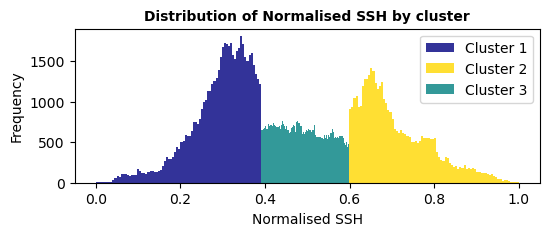

In [9]:
# Plotting the clustered data
ssh_list = ssh_list.flatten() # convert from list to string
cluster_class = eddies

# Separate normalised ssh val by cluster
cluster0 = ssh_list[cluster_class == 0]
cluster1 = ssh_list[cluster_class == 1]
cluster2 = ssh_list[cluster_class == 2]

# Plot norm ssh data clusters:
plt.figure(figsize = (6, 2))
plt.hist(cluster0, bins=80, alpha=0.8, label='Cluster 1', color='navy')
plt.hist(cluster1, bins=80, alpha=0.8, label='Cluster 2', color='gold')
plt.hist(cluster2, bins=80, alpha=0.8, label='Cluster 3', color='teal')

# Format nicely
plt.xlabel("Normalised SSH")
plt.ylabel("Frequency")
plt.title("Distribution of Normalised SSH by cluster", 
          fontsize = 10, weight = 'bold')

# Show plot
plt.legend()
plt.show()

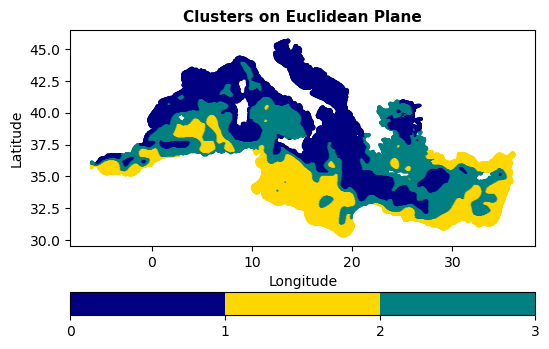

In [10]:
from matplotlib.colors import BoundaryNorm, ListedColormap

# Make a bespoke colourbar for your 3 clusters
cmap3 = ListedColormap(['navy', 'gold', 'teal'])
# Set colourbar boundaries for n=3 clusters
bounds = [0, 1, 2, 3]
norm = BoundaryNorm(bounds, cmap3.N)

# Create a 2D meshgrid for coordinates
lon2d, lat2d = np.meshgrid(lon, lat)

# Extract valid (ocean) coordinates using the mask
valid_lon = lon2d[mask]
valid_lat = lat2d[mask]

# Plot clusters on an Euclidean plane using the custom colormap and norm
plt.figure(figsize=(6, 4))
# Classes (clusters) using scatterplot
plt.scatter(valid_lon, valid_lat, c = ssh_grid[mask], cmap = cmap3, norm = norm, s = 1)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Clusters on Euclidean Plane", fontsize = 11, weight = 'bold')
# Colourbar
plt.colorbar(orientation = 'horizontal', ticks = [0, 1, 2, 3])

plt.show()

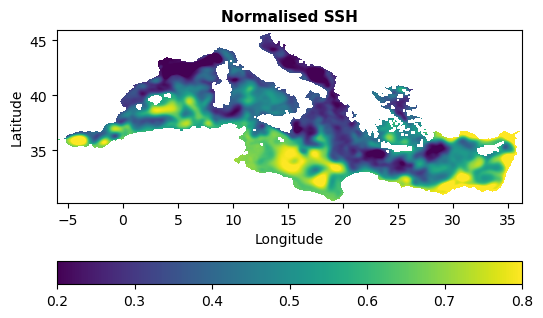

In [11]:
# Plot the normalized SSH vals
plt.figure(figsize=(6, 5))
plt.imshow(ssh_norm, extent=[lon.min(), lon.max(), lat.min(), lat.max()], 
           origin='lower', cmap = 'viridis', vmin = 0.2, vmax = 0.8)
           #cmap=cmap3, origin='lower', norm=norm)
plt.xlabel('Longitude')         
plt.ylabel('Latitude' )   
plt.title("Normalised SSH", fontsize=11, weight='bold')
# Colourbar
plt.colorbar(orientation='horizontal')

plt.show()